In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

In [2]:
from newton import riemann_solver_newton

import numpy as np
import pandas as pd

In [ ]:
def generate_training_data(riemann_solver_newton, num_samples=1000, 
                           h_min=0.01, h_max=10.0, 
                           hu_min=-10.0, hu_max=10.0):
    """
    Generate training samples for a neural network using a Riemann solver.

    Parameters:
        riemann_solver_newton: function
            The Riemann solver function that computes (h*, u*) given (hL, huL, hR, huR).
        num_samples: int
            Number of samples to generate.
        h_min: float
            Minimum value for water depth h (hL, hR).
        h_max: float
            Maximum value for water depth h (hL, hR).
        hu_min: float
            Minimum value for momentum hu (huL, huR).
        hu_max: float
            Maximum value for momentum hu (huL, huR).

    Returns:
        DataFrame
            A pandas DataFrame containing the input values (hL, huL, hR, huR) and output values (h*, u*).
    """
    # Initialize lists to store input and output samples
    inputs = []
    outputs = []


    from test2 import generate_log_uniform_sample
    for _ in range(num_samples):
        # Randomly sample input values within the specified domain
        hL = np.random.uniform(h_min, h_max)
        huL = np.random.uniform(hu_min, hu_max)
        hR = np.random.uniform(h_min, h_max)
        huR = np.random.uniform(hu_min, hu_max)
        # hL = generate_log_uniform_sample(h_min, h_max)
        # huL = (-1) ** (np.random.random() > 0.5) * generate_log_uniform_sample(0.01, hu_max)
        # hR = generate_log_uniform_sample(h_min, h_max)
        # huR = (-1) ** (np.random.random() > 0.5) * generate_log_uniform_sample(0.01, hu_max)

        # Compute the Riemann solution
        data = riemann_solver_newton(hL, huL, hR, huR, tol=1e-12)
        # print(data)
        h_star, u_star = data['star']
        k = data['data'].item()
        
        
        

        # Store the inputs and outputs
        inputs.append([hL, huL, hR, huR])
        outputs.append([h_star, u_star, k])

    # Convert to pandas DataFrame for easy handling
    df = pd.DataFrame(
        data=np.hstack([inputs, outputs]),
        columns=['hL', 'huL', 'hR', 'huR', 'h_star', 'u_star', 'iter']
    )

    return df

# Example usage
# Assuming riemann_solver_newton is defined elsewhere and computes (h_star, hu_star)
# Replace the function definition below with the actual implementation
# def riemann_solver_newton(hL, huL, hR, huR):
#     # Placeholder example: Replace with the actual solver logic
#     h_star = 0.5 * (hL + hR)  # Example logic
#     hu_star = 0.5 * (huL + huR)  # Example logic
#     return h_star, hu_star

# Generate training data
num_samples = 20000
data = generate_training_data(riemann_solver_newton, num_samples=num_samples)

# Save to CSV file
data.to_csv("riemann_training_data2.csv", index=False)
print(f"Generated {num_samples} training samples and saved to 'riemann_training_data.csv'")


In [45]:
from sklearn.model_selection import train_test_split

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('riemann_training_data2.csv')  # Replace with your actual file path

# Define input features and output features
X = df[['hL', 'huL', 'hR', 'huR']]
X['ghL'] = np.sqrt(9.8066 * df['hL'])
X['ghR'] = np.sqrt(9.8066 * df['hR'])
y = df[['h_star', 'u_star']]

# Split the data into training and validation sets
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training input shape: {train_X.shape}")
print(f"Validation input shape: {val_X.shape}")
print(f"Training output shape: {train_y.shape}")
print(f"Validation output shape: {val_y.shape}")


Training input shape: (16000, 6)
Validation input shape: (4000, 6)
Training output shape: (16000, 2)
Validation output shape: (4000, 2)


/tmp/ipykernel_55741/2077566736.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ghL'] = np.sqrt(9.8066 * df['hL'])
/tmp/ipykernel_55741/2077566736.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ghR'] = np.sqrt(9.8066 * df['hR'])


In [46]:
# Convert pandas DataFrames to PyTorch tensors
train_X_tensor = torch.tensor(train_X.values, dtype=torch.float32)
val_X_tensor = torch.tensor(val_X.values, dtype=torch.float32)
train_y_tensor = torch.tensor(train_y.values, dtype=torch.float32)
val_y_tensor = torch.tensor(val_y.values, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
val_dataset = TensorDataset(val_X_tensor, val_y_tensor)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")


Training dataset size: 16000
Validation dataset size: 4000


In [47]:
train_dataset[0]

(tensor([ 7.1846,  1.7619,  2.9987, -5.6217,  8.3938,  5.4228]),
 tensor([5.5873, 2.2286]))

In [48]:
# Define batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training DataLoader batches: {len(train_loader)}")
print(f"Validation DataLoader batches: {len(val_loader)}")

Training DataLoader batches: 500
Validation DataLoader batches: 125


In [49]:
from torch.nn.functional import relu, elu, batch_norm

In [55]:
class MLP(nn.Module):
    def __init__(self, input_features):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_features, 20)
        self.layer2 = nn.Linear(20, 20)
        self.layer3 = nn.Linear(20, 20)
        self.layer4 = nn.Linear(20, 20)
        self.layer5 = nn.Linear(20, 2)
        self.activation = elu
        self.bn = nn.BatchNorm1d(4)

    def forward(self, x):
        # if x.dim() == 1:
        #     x = x.unsqueeze(1)
        # x = self.bn(x)
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.activation(self.layer4(x))
        x = self.layer5(x)
        return x

# Example usage
input_features = 6  # Specify the number of input features
model = MLP(input_features)

print(model)


MLP(
  (layer1): Linear(in_features=6, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=20, bias=True)
  (layer4): Linear(in_features=20, out_features=20, bias=True)
  (layer5): Linear(in_features=20, out_features=2, bias=True)
  (bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [57]:
class MSE_Loss_Scaled(torch.nn.Module):
    """
    Mean-squared error loss with custom scaling factors
    for each label component.
    """

    def __init__(self):
        super().__init__()
        # self.register_buffer("scaling_factors", torch.tensor(scaling_factors))

    def forward(self, input, target, scale):
        mse = torch.mean((input - target) ** 2, dim=0)
        mse = torch.dot(scale, mse)
        return mse

In [58]:
def train_model(model, train_dataloader, val_dataloader, num_epochs=10, learning_rate=0.001):
    # criterion = nn.MSELoss()
    criterion = MSE_Loss_Scaled()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    # fig, ax = plt.subplots()  # Create a figure and axis for plotting
    # line, = ax.plot([], [], 'b-')  # Initialize the plot line
    # 
    # ax.set_xlabel('Epoch')
    # ax.set_ylabel('Loss')
    # ax.set_title('Training Loss History')

    # plt.ion()  # Turn on interactive mode for real-time updates
    # fig.canvas.draw()

    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        for inputs, targets in train_dataloader:
            optimizer.zero_grad()

            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device), 1. / targets.std(dim=0).to(device))
            # print(loss.shape, loss, targets.std(dim=0).shape)
            # loss /= targets.std(dim=0)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        train_losses.append(epoch_loss)
        
        model.eval()
        for inputs, targets in val_dataloader:
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device), 1. / targets.std(dim=0).to(device))
            
            running_loss += loss.item() * inputs.size(0)
            
        epoch_loss = running_loss / len(val_dataloader.dataset)
        val_losses.append(epoch_loss)
            
            
        
        clear_output()
        fig, axis = plt.subplots(1, 1, figsize=(7, 7))
        axis.plot(np.arange(1, epoch + 2), train_losses, label='train')
        axis.plot(np.arange(1, epoch + 2), val_losses, label='val')
        # axis[1].plot(np.arange(1, epoch + 2), train_accs, label='train')
        # axis[1].plot(np.arange(1, epoch + 2), val_accs, label='val')
        axis.set(xlabel='epoch', ylabel='MSE Loss')
        # axis.set(xlabel='epoch', ylabel='Accuracy')
        fig.legend()
        plt.show()
        print(f'Epoch {epoch + 1}.')
        print(f'Train loss {train_losses[-1]}.')
        print(f'Test loss {val_losses[-1]}.')
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_losses[-1]:.4f}')
        # Update the plot
        # line.set_xdata(range(len(loss_history)))
        # line.set_ydata(loss_history)
        # ax.relim()
        # ax.autoscale_view()
        # fig.canvas.draw()
        # plt.pause(0.1)  # Pause briefly to update the plot

    # plt.ioff()  # Turn off interactive mode after training
    # plt.show()

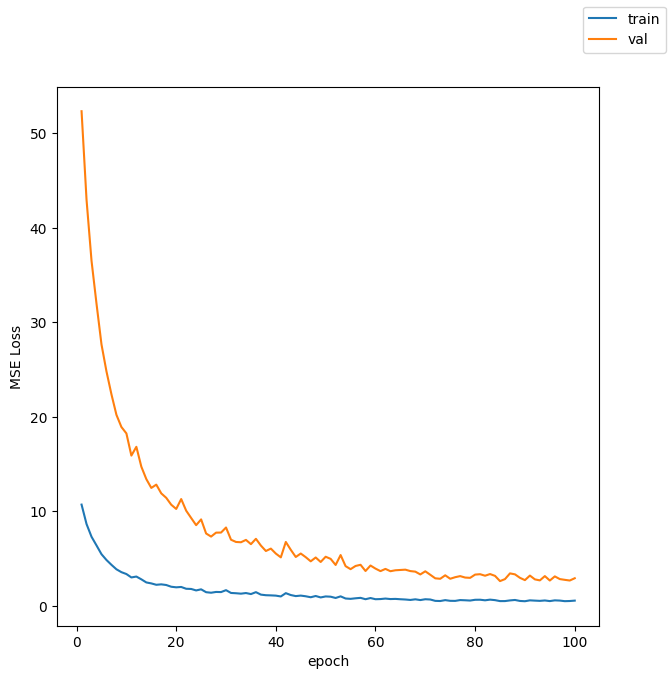

Epoch 100.
Train loss 0.5566044686799869.
Test loss 2.9256444563679396.
Epoch 100/100, Loss: 0.5566


In [59]:
model = MLP(input_features)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(model.to(device), train_loader, val_loader, num_epochs=100)

In [60]:
inputs = val_dataset[:2]
# inputs = torch.tensor([[5, 0, 5, 0], [2, 1, 2, 1]], dtype=torch.float32)

In [61]:
out = inputs[1]
out

tensor([[ 1.7543, -2.6047],
        [ 3.8234, -6.1233]])

In [62]:
out.mean(dim=0)

tensor([ 2.7889, -4.3640])

In [63]:
model.to(device)
model(inputs[0].to(device))

tensor([[ 1.8385, -2.8146],
        [ 3.6216, -6.5347]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [66]:
def godunov_shallow_water(h, hu, dx, dt, iter=0, g=9.81):
    """
    Solve the 1D shallow water equations using the Godunov scheme.

    Parameters:
    - h: numpy array, water depth
    - hu: numpy array, momentum (h * u)
    - dx: float, spatial resolution
    - dt: float, time step
    - g: float, gravitational acceleration (default 9.81 m/s^2)

    Returns:
    - h_new: numpy array, updated water depth
    - hu_new: numpy array, updated momentum
    """

    def flux(h, hu):
        """Compute the physical flux for shallow water equations."""
        u = np.where(h > 0, hu / h, 0)  # Avoid division by zero
        return np.array([hu, hu * u + 0.5 * g * h ** 2])

    global riemann_solver
    def riemann_solver(hL, huL, hR, huR):
        """Solve Riemann problem for shallow water equations."""
        uL = huL / hL if hL > 0 else 0
        uR = huR / hR if hR > 0 else 0

        # Compute fluxes for left and right states
        FL = flux(hL, huL)
        FR = flux(hR, huR)

        # Roe averages
        hRoe = max(0, 0.5 * (hL + hR))  # Ensure positivity of h
        if hL + hR > 0:
            uRoe = (np.sqrt(hL) * uL + np.sqrt(hR) * uR) / (np.sqrt(hL) + np.sqrt(hR))
        else:
            uRoe = 0
        cRoe = np.sqrt(g * hRoe)

        # Wave speeds
        sL = min(uL - np.sqrt(g * hL), uRoe - cRoe)
        sR = max(uR + np.sqrt(g * hR), uRoe + cRoe)

        # Flux computation
        if sL >= 0:
            return FL
        elif sR <= 0:
            return FR
        else:
            # Flux in the intermediate region
            part = (sR * FL - sL * FR + sL * sR * (np.array([hR, huR]) - np.array([hL, huL]))) / (sR - sL)
            part = np.append(part, [hRoe, uRoe])
            return part

    global riemann_solver_iter
    def riemann_solver_iter(hL, huL, hR, huR, g=9.81, tol=1e-6, max_iter=1000):
        """
        Exact Riemann solver for the shallow water equations using Newton's method.

        Parameters:
        - hL: float, water depth on the left
        - huL: float, momentum on the left
        - hR: float, water depth on the right
        - huR: float, momentum on the right
        - g: float, gravitational acceleration
        - tol: float, tolerance for Newton's method
        - max_iter: int, maximum number of iterations for Newton's method

        Returns:
        - Flux at the interface as a numpy array [F_h, F_hu]
        """
        # Compute velocities on the left and right
        uL = huL / hL if hL > 0 else 0
        uR = huR / hR if hR > 0 else 0

        # Function to solve for h_star
        def f(h_star):
            """Nonlinear equation for h_star."""
            termL = (h_star - hL) * (np.sqrt(0.5 * g * (h_star + hL)))
            termR = (h_star - hR) * (np.sqrt(0.5 * g * (h_star + hR)))
            return termL + termR + (uR - uL)

        def df(h_star):
            """Derivative of f(h_star)."""
            termL = np.sqrt(0.5 * g * (h_star + hL)) + 0.5 * g * (h_star - hL) / np.sqrt(0.5 * g * (h_star + hL))
            termR = np.sqrt(0.5 * g * (h_star + hR)) + 0.5 * g * (h_star - hR) / np.sqrt(0.5 * g * (h_star + hR))
            return termL + termR

        # Initial guess for h_star (arithmetic mean of hL and hR)
        h_star = 0.5 * (hL + hR)

        # Newton's method to find h_star
        for _ in range(max_iter):
            f_val = f(h_star)
            df_val = df(h_star)
            if abs(f_val) < tol:  # Convergence check
                break
            h_star -= f_val / df_val
        else:
            raise RuntimeError("Newton's method failed to converge for h_star")

        # Compute the intermediate velocity
        u_star = 0.5 * (uL + uR) - 0.5 * (np.sqrt(g / h_star) * (hR - hL))

        # Compute fluxes based on the solution
        F_h = h_star * u_star
        F_hu = h_star * u_star ** 2 + 0.5 * g * h_star ** 2

        return np.array([F_h, F_hu, h_star, u_star])

    # Number of cells
    n = len(h)

    # Compute fluxes at interfaces
    h_flux = np.zeros(n - 1)
    hu_flux = np.zeros(n - 1)
    hh = np.zeros(n - 1)
    uu = np.zeros(n - 1)
    for i in range(n - 1):
        if not iter:
            flux_i = riemann_solver(h[i], hu[i], h[i + 1], hu[i + 1])
        elif iter == 1:
            flux_i = riemann_solver_iter(h[i], hu[i], h[i + 1], hu[i + 1])
        elif iter == 2:
            # print(i, h[i], hu[i], h[i + 1], hu[i + 1])
            flux_i = riemann_solver_newton(h[i], hu[i], h[i + 1], hu[i + 1])['flux']
        elif iter == 3:
            inputs = torch.tensor([h[i], hu[i], h[i + 1], hu[i + 1], np.sqrt(g * h[i]), np.sqrt(g * h[i + 1])], dtype=torch.float32)
            h_star, u_star = model(inputs.to(device)).cpu().detach().numpy()
            
            F_h = h_star * u_star
            F_hu = h_star * u_star ** 2 + 0.5 * g * h_star ** 2
            
            flux_i = [F_h, F_hu, h_star, u_star]
        h_flux[i], hu_flux[i], hh[i], uu[i] = flux_i

    # print(f"Method {iter}: ", h_flux)
    # print(f"Method {iter}: ", hu_flux)
    # print(f"Method {iter}: ", hh)
    # print(f"Method {iter}: ", uu)
    # Update h and hu using flux differences
    h_new = h.copy()
    hu_new = hu.copy()
    for i in range(1, n - 1):
        h_new[i] -= dt / dx * (h_flux[i] - h_flux[i - 1])
        hu_new[i] -= dt / dx * (hu_flux[i] - hu_flux[i - 1])

    # Enforce positivity of h
    h_new = np.maximum(h_new, 0)
    return h_new, hu_new

[5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


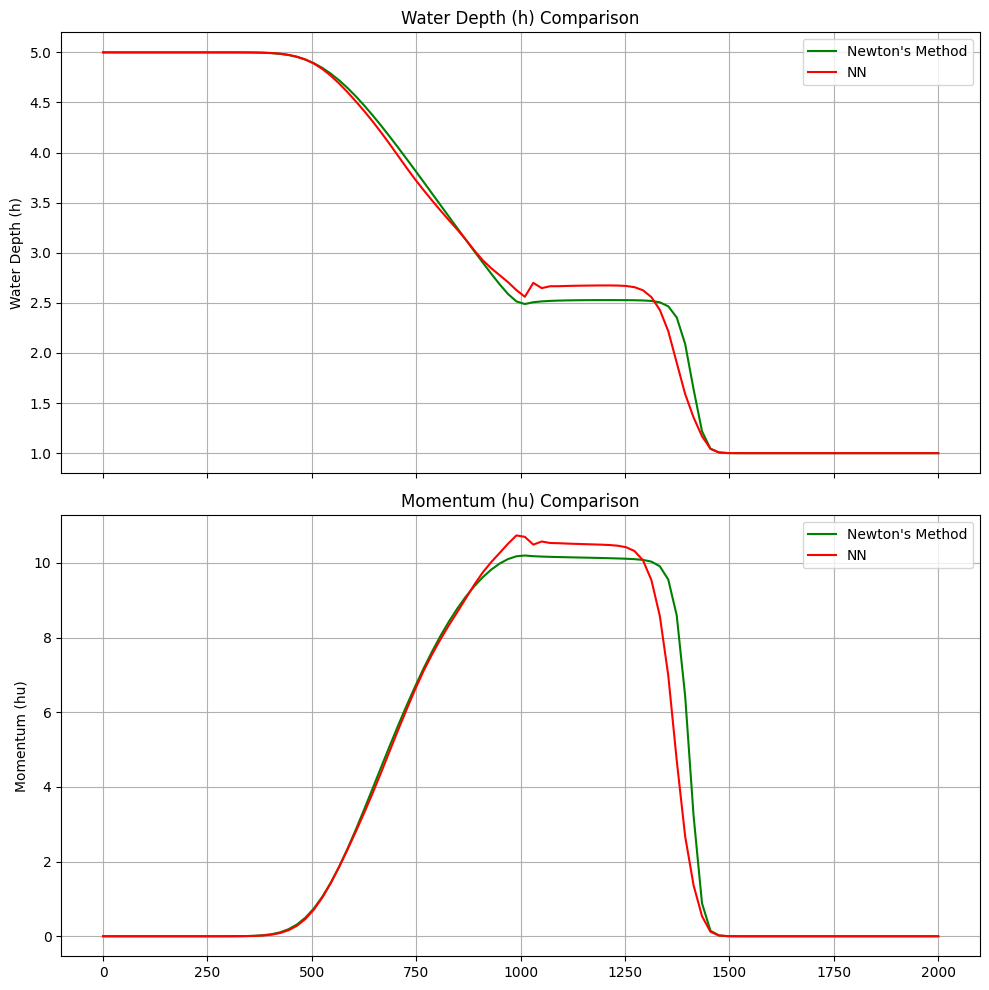

In [67]:
# Simulation setup
L = 2000.0  # Domain length (m)
nx = 100  # Number of spatial points
dx = L / nx  # Spatial resolution
g = 9.8066  # Gravitational acceleration (m/s^2)
CFL = 0.5  # CFL condition

# Initial conditions
h = np.ones(nx)
h[:nx//2] = 5  # Step in water depth
# h[nx // 4:nx //2] = 10  # Step in water depth
u = np.zeros(nx)
hu = h * u  # Momentum (initially zero)
# hu[:nx // 5] = 2.5
print(h, hu, sep='\n')

# Updated time-stepping loop to compute solutions with both solvers
# h_iter = h.copy()  # Initial condition for iterative solver
# hu_iter = hu.copy()
# h_newton = h.copy()
# hu_newton = hu.copy()
# h_approx = h.copy()
# hu_approx = hu.copy()

# # Initialize time
# t = 0.0
# h_history_approx = []  # Store water depth from approximate solver
# h_history_iter = []    # Store water depth from iterative solver

t_end = 60  # Simulation end time
def compute(h, hu, solver=0):
    t = 0.0
    while t < t_end:
        # Compute maximum wave speed for CFL condition
        # if solver == 3:
        #     print(h)
        u = np.where(h > 0, hu / h, 0)
        c = np.sqrt(g * h)
        dt = CFL * dx / (np.max(np.abs(u) + c))  # Adaptive time step

        # if solver == 2:
            # print(t)
        h, hu = godunov_shallow_water(h, hu, dx, dt, iter=solver, g=g)

        # Advance time
        t += dt

    return h, hu

# h_approx, hu_approx = compute(h, hu, solver=0)
# h_iter, hu_iter = compute(h, hu, solver=1)
h_newton, hu_newton = compute(h, hu, solver=2)
h_nn, hu_nn = compute(h, hu, solver=3)

# Plot final results using subplots
x = np.linspace(0, L, nx)

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Plot water depth (h)
# axes[0].plot(x, h_approx, label='Approximate Solve', linestyle='-', color='blue')
# axes[0].plot(x, h_iter, label='Iterative Solver', linestyle='-', color='orange')
axes[0].plot(x, h_newton, label='Newton\'s Method', linestyle='-', color='green')
axes[0].plot(x, h_nn, label='NN', linestyle='-', color='red')
axes[0].set_ylabel('Water Depth (h)')
axes[0].legend()
axes[0].grid()
axes[0].set_title('Water Depth (h) Comparison')

# Plot momentum (hu)
# axes[1].plot(x, hu_approx, label='Approximate Solver', linestyle='-', color='blue')
# axes[1].plot(x, hu_iter, label='Iterative Solver', linestyle='-', color='orange')
axes[1].plot(x, hu_newton, label='Newton\'s Method', linestyle='-', color='green')
axes[1].plot(x, hu_nn, label='NN', linestyle='-', color='red')
axes[1].set_ylabel('Momentum (hu)')
axes[1].legend()
axes[1].grid()
axes[1].set_title('Momentum (hu) Comparison')

# Adjust layout
plt.tight_layout()


# Save the plot as a PNG file
plt.savefig('myplot.png')

plt.show()

In [131]:
riemann_solver_newton(1, 1, 2, -1)

{'flux': array([-1.88220648, 17.00892416,  1.74800966, -1.07677121]),
 'star': array([ 1.74800966, -1.07677121]),
 'data': array([3])}

In [134]:
riemann_solver_newton(2, 1, 4, -1)

{'flux': array([-5.38032341, 56.75790812,  3.11089783, -1.72950823]),
 'star': array([ 3.11089783, -1.72950823]),
 'data': array([3])}